# Imports

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import os

# Preprocessing

In [11]:
folder_path = 'images'

files = os.listdir(folder_path)

image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
image_files = [file for file in files if os.path.splitext(file)[1].lower() in image_extensions]

# for image in image_files:
#     print(os.path.join(folder_path, image))


### Here we make some changes on the size of each image

In [12]:
def read_imgs(path):
    image = cv.imread(path) 
     
    # Resize the image to 200x200
    resized_image = cv.resize(image, (200, 200))

    # Rescale the image by a factor of 4
    rescaled_image = cv.resize(image, None, fx=4, fy=4, interpolation=cv.INTER_LINEAR)
    return image, resized_image, rescaled_image



list_of_images = []
for image in image_files:
    image, resized_image, rescaled_image = read_imgs(os.path.join(folder_path, image))
    list_of_images.append(rescaled_image)


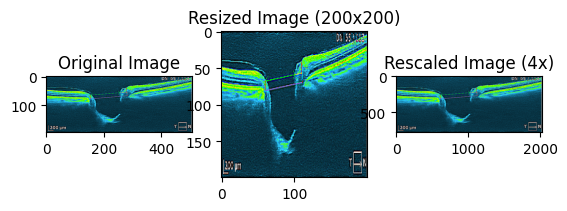

In [13]:

# Display the results
plt.subplot(131), plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(132), plt.imshow(cv.cvtColor(resized_image, cv.COLOR_BGR2RGB)), plt.title('Resized Image (200x200)')
plt.subplot(133), plt.imshow(cv.cvtColor(rescaled_image, cv.COLOR_BGR2RGB)), plt.title('Rescaled Image (4x)')
plt.show()


### Making morphological operations on the images

In [20]:
def morph_operations(image):
    # Define a kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)

    # Erosion
    erosion = cv.erode(image, kernel, iterations=1)

    # Dilation
    dilation = cv.dilate(image, kernel, iterations=1)
    return erosion, dilation

erosion_images = []
dilation_images = []
for image in list_of_images:
    erosion, dilation = morph_operations(image)
    erosion_images.append(erosion)
    dilation_images.append(dilation)

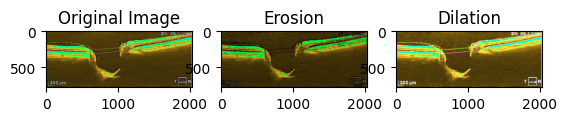

In [21]:
# Display the results
plt.subplot(131), plt.imshow(rescaled_image), plt.title('Original Image')
plt.subplot(132), plt.imshow(erosion), plt.title('Erosion')
plt.subplot(133), plt.imshow(dilation), plt.title('Dilation')
plt.show()

(<matplotlib.image.AxesImage at 0x12e525b0bd0>, Text(0.5, 1.0, 'erosion'))

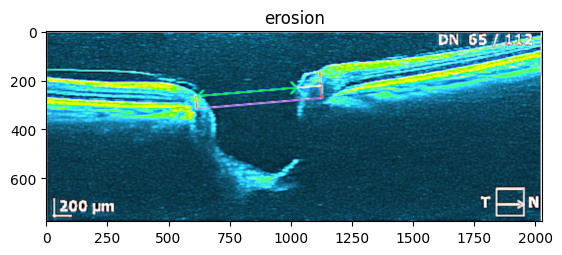

In [23]:
plt.imshow(cv.cvtColor(dilation, cv.COLOR_BGR2RGB)), plt.title('erosion')


(<matplotlib.image.AxesImage at 0x12e2a4ba950>, Text(0.5, 1.0, 'erosion'))

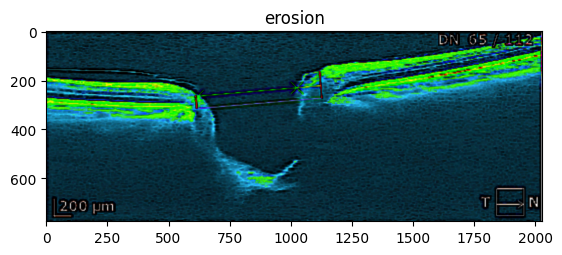

In [18]:
plt.imshow(cv.cvtColor(erosion, cv.COLOR_BGR2RGB)), plt.title('erosion')


In [37]:
def gaussian_blur(dilation_or_erosion):
    # Apply Gaussian blur to reduce noise
    blurred_image = cv.GaussianBlur(dilation_or_erosion, (5, 5), 0)

    # to gray
    image_gray = cv.cvtColor(blurred_image,cv.COLOR_BGR2GRAY)

    # Apply Canny edge detector
    edges = cv.Canny(image_gray, 10.0, 50.0)
    return blurred_image, edges

blurred_images_list = []
edges_liat = []
for image in dilation_images:
    blurred_image, edges = gaussian_blur(image)
    blurred_images_list.append(blurred_image)
    edges_liat.append(edges)

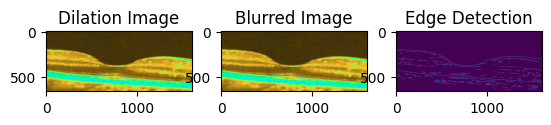

In [41]:
# Display the results
plt.subplot(131), plt.imshow(dilation_images[5]), plt.title('Dilation Image')
plt.subplot(132), plt.imshow(blurred_images_list[5]), plt.title('Blurred Image')
plt.subplot(133), plt.imshow(edges_liat[5]), plt.title('Edge Detection')
plt.show()

(<matplotlib.image.AxesImage at 0x12e52616ed0>,
 Text(0.5, 1.0, 'Edge Detection'))

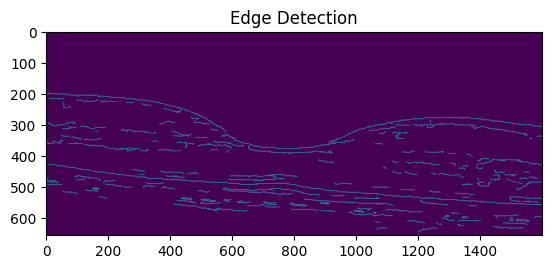

In [42]:
plt.imshow(edges_liat[5]), plt.title('Edge Detection')


In [43]:
def threshold(edges):
    # thresholding:
    threshold_value = 127
    _, binary_image = cv.threshold(edges, threshold_value, 255, cv.THRESH_BINARY)
    return binary_image

binary_image_list = []
for image in edges_liat:
    binary_image = threshold(image)
    binary_image_list.append(binary_image)

(<matplotlib.image.AxesImage at 0x12e524a7c90>, Text(0.5, 1.0, 'Thresholding'))

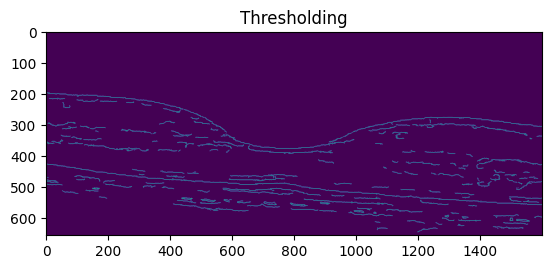

In [44]:
plt.imshow(binary_image_list[5]), plt.title('Thresholding')


In [45]:
binary_image_list[5].shape


(656, 1600)

In [65]:

# Function to perform ORB feature extraction
def extract_orb_features(image):

    orb = cv.ORB_create()
    kp = orb.detect(image, None)
    img2 = cv.drawKeypoints(image, kp, None)

    keypoints, descriptors = orb.detectAndCompute(image, None)

    # if keypoints is not None:
    #     print("Number of Keypoints:", len(keypoints))
    # if descriptors is not None:
    #     print("ORB Descriptors Shape:", descriptors.shape)

    img_with_keypoints = cv.drawKeypoints(image, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    m00 = np.sum(image)
    m10 = np.sum(np.multiply(np.arange(image.shape[1]), np.sum(image, axis=0)))
    m01 = np.sum(np.multiply(np.arange(image.shape[0]), np.sum(image, axis=1)))
    centroid_x = m10 / m00
    centroid_y = m01 / m00

    # Calculate the angle between moments
    alpha = np.degrees(np.arctan2(centroid_y, centroid_x))

    # print("Centroid (x, y):", (centroid_x, centroid_y))
    # print("Angle between moments (alpha):", alpha)

   
    return {
        # 'image2_with_keypoints': img2,
        'image_with_keypoints': img_with_keypoints,
        'keypoints': keypoints,
        'descriptors': descriptors,
        'centroid_x': centroid_x,
        'centroid_y': centroid_y,
        'alpha': alpha
    }

# Function to process multiple images and store results in a DataFrame
def process_images(images):
    data = []

    for image in images:
        features = extract_orb_features(image)
        data.append({
            # 'image_name': os.path.basename(paths),
            'num_keypoints': len(features['keypoints']) if features['keypoints'] is not None else 0,
            'descriptors_shape': features['descriptors'].shape if features['descriptors'] is not None else (0, 0),
            'centroid_x': features['centroid_x'],
            'centroid_y': features['centroid_y'],
            'alpha': features['alpha'],
            # 'image2_with_keypoints': features['image2_with_keypoints'],
            'image_with_keypoints': features['image_with_keypoints']
        })

    return pd.DataFrame(data)



In [66]:
# for image in image_files:
#     print(os.path.join(folder_path, image))

# Sample usage with a list of image paths
df = process_images(binary_image_list)

# Display the DataFrame
df


,num_keypoints,descriptors_shape,centroid_x,centroid_y,alpha,image_with_keypoints
0,500,"(500, 32)",1723.013580,2941.793592,59.642420,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,500,"(500, 32)",1109.815127,195.517276,9.991334,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,500,"(500, 32)",1529.454969,1043.937837,34.315704,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,500,"(500, 32)",1598.009181,620.708477,21.227469,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,500,"(500, 32)",1504.297657,1120.896331,36.690876,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
5,500,"(500, 32)",825.321318,443.259496,28.239136,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
6,500,"(500, 32)",1546.529414,1446.530808,43.086451,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
7,500,"(500, 32)",2354.673647,620.680714,14.766994,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
8,500,"(500, 32)",4391.854709,1771.812821,21.970704,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
9,500,"(500, 32)",2729.040404,1117.219114,22.263293,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [67]:
# # Display keypoints on the first image as an example
# plt.figure(figsize=(8, 8))
# plt.imshow(df.iloc[5]['image2_with_keypoints'], cmap='gray')
# plt.title(f'ORB Keypoints on {df.iloc[5]}')
# plt.axis('off')
# plt.show()

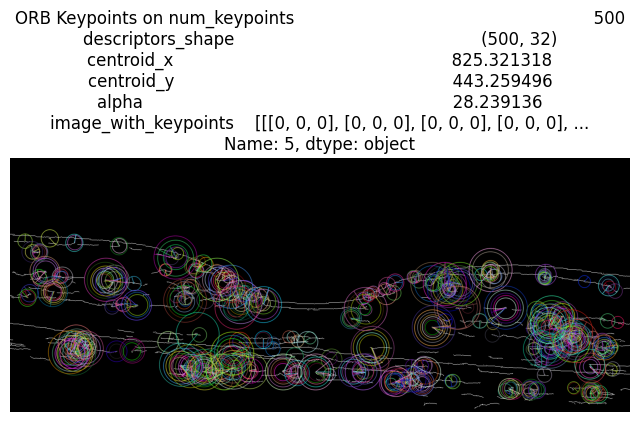

In [68]:
plt.figure(figsize=(8, 8))
plt.imshow(df.iloc[5]['image_with_keypoints'], cmap='gray')
plt.title(f'ORB Keypoints on {df.iloc[5]}')
plt.axis('off')
plt.show()

Number of Keypoints: 500
ORB Descriptors Shape: (500, 32)
Centroid (x, y): (825.3213183025778, 443.25949594313204)
Angle between moments (alpha): 28.239136367129827


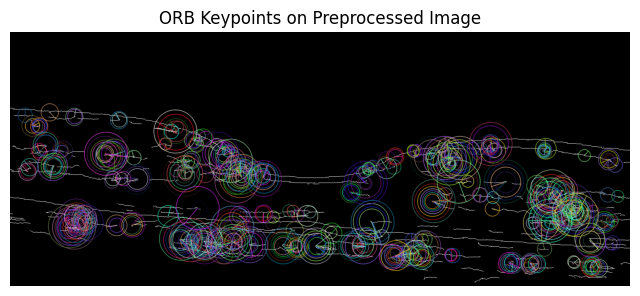

,x,y,size,angle,response,octave,class_id,0,1,2,...,22,23,24,25,26,27,28,29,30,31
0,824.0,559.0,31.0,98.454460,0.010621,0,-1,24,16,6,...,247,20,196,227,65,1,99,36,46,208
1,730.0,463.0,31.0,74.513535,0.010666,0,-1,72,58,26,...,138,49,83,129,33,185,88,0,15,211
2,1482.0,320.0,31.0,310.367950,0.010054,0,-1,96,4,192,...,5,14,32,166,32,16,100,130,66,0
3,1504.0,463.0,31.0,256.758362,0.008591,0,-1,98,33,2,...,202,17,152,20,9,62,0,2,19,4
4,1397.0,494.0,31.0,306.479340,0.009465,0,-1,90,48,129,...,209,0,209,225,141,19,38,36,20,50


In [56]:
# Function to perform ORB feature extraction and save to DataFrame
def extract_orb_features(image):
    # Initialize ORB detector
    orb = cv.ORB_create()
    
    # Detect keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
    
    # Print the number of keypoints and descriptors
    print("Number of Keypoints:", len(keypoints))
    print("ORB Descriptors Shape:", descriptors.shape)
    
    # Visualize the keypoints on the image
    img_with_keypoints = cv.drawKeypoints(image, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Calculate the moment and centroid
    m00 = np.sum(image)
    m10 = np.sum(np.multiply(np.arange(image.shape[1]), np.sum(image, axis=0)))
    m01 = np.sum(np.multiply(np.arange(image.shape[0]), np.sum(image, axis=1)))
    centroid_x = m10 / m00
    centroid_y = m01 / m00
    
    # Calculate the angle between moments
    alpha = np.degrees(np.arctan2(centroid_y, centroid_x))
    
    print("Centroid (x, y):", (centroid_x, centroid_y))
    print("Angle between moments (alpha):", alpha)
    
    # Convert keypoints to a DataFrame
    keypoints_list = []
    for kp in keypoints:
        keypoints_list.append([kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id])
    
    keypoints_df = pd.DataFrame(keypoints_list, columns=['x', 'y', 'size', 'angle', 'response', 'octave', 'class_id'])
    
    # Convert descriptors to a DataFrame
    descriptors_df = pd.DataFrame(descriptors)
    
    # Combine keypoints and descriptors into a single DataFrame
    features_df = pd.concat([keypoints_df, descriptors_df], axis=1)
    
    # Optionally save the DataFrame to a file (CSV format)
    features_df.to_csv('orb_features.csv', index=False)
    
    return img_with_keypoints, features_df

# Sample usage
orb_img, features_df = extract_orb_features(binary_image_list[5])

# Display the image with keypoints
plt.figure(figsize=(8, 8))
plt.imshow(orb_img, cmap='gray')
plt.title('ORB Keypoints on Preprocessed Image')
plt.axis('off')
plt.show()

# Display the DataFrame (for verification)
features_df.head()
